**Model 1**



In [3]:
#librosa 只有第一次需要裝

!pip install librosa

  Using cached https://files.pythonhosted.org/packages/28/5c/cf6a2b65a321c4a209efcdf64c2689efae2cb62661f8f6f4bb28547cf1bf/joblib-0.14.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/eb/f2/3cbbbf3b96fb9fa91582c438b574cff3f45b29c772f94c400e2c99ef5db9/SoundFile-0.10.3.post1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ba/49/61522f34b1333aa4e9aa02005dc0774d25bd234400dff718b16615d6a744/numba-0.48.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ad/bb/60d4033d56c9da36490af19caa6c794b72b8aef6f792fdfa8cb95d11e419/llvmlite-0.31.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: llvmlite 0.23.0
    Uninstalling llvmlite-0.23.0:
      Successfully uninstalled llvmlite-0.23.0
  Found existing installation: numba 0.38.1
    Uninstalling numba-0.38.1:
      Successfully uninstalled numba-0.38.1


In [4]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

In [5]:
#載入所有需要的套件

import librosa
from librosa import display
import time
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import keras
#import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 進行建模事前準備
## 設定檔

In [6]:
# path = '../../dataset/ravdess_datasets/Audio_Song_Actors/Actor_01'
path = '/home/jovyan/at083-group21/dataset/ravdess_datasets/'

lst = []
#save_dir = 'joblib'

## Data Augmentation

In [7]:
# Trim db 30
def trim(data):
    data, index = librosa.effects.trim(data, top_db=30, frame_length=1024, hop_length=512) # default frame_length=2048, hop_length=512
    return data

##  讀資料

In [ ]:
#trim
## Trim

start_time = time.time()
print("--- Start load Data. Start time: %s ---" % (start_time))
for subdir, dirs, files in os.walk(path):

    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
            X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
            
            #####Data Augmentation
                        
            X = trim(X)
            sample_rate = np.array(sample_rate)

            
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=100).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
            file = int(file[7:8]) - 1 
            arr = mfccs, file
            lst.append(arr)
          # If the file is not valid, skip it
        except ValueError:
            continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Start load Data. Start time: 1585707887.4737136 ---


In [6]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [7]:
X = np.asarray(X)
y = np.asarray(y)
X.shape, y.shape

((2244, 100), (2244,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [10]:
x_traincnn.shape, x_testcnn.shape

((1503, 100, 1), (741, 100, 1))

In [11]:

# Saving joblib files to not load them again with the loop above
X_name = 'Adam_trim_only_aug_X.joblib'
y_name = 'Adam_trim_only_aug_y.joblib'
save_dir = '/home/jovyan/project_model_training/final_test_folder/20200327/'
#save_dir = 'joblib'
savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))


In [4]:
# Loading saved models

#save_dir = '/home/jovyan/project_model_training/final_test_folder/20200326_Adam_data_augmentation/'
save_dir = '/home/jovyan/project_model_training/final_test_folder/20200327/'

X = joblib.load(f'{save_dir}/Adam_trim_only_aug_X.joblib')
y = joblib.load(f'{save_dir}/Adam_trim_only_aug_y.joblib')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

x_traincnn.shape, x_testcnn.shape

((1503, 100, 1), (741, 100, 1))

### 模型3: Neural network

In [5]:
from keras.layers.convolutional import Convolution1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU, PReLU, LeakyReLU
import tensorflow as tf

opt = keras.optimizers.Adam(lr=0.00001, decay=1e-6)

model = Sequential()

model.add(Conv1D(128, 5, padding='same', input_shape=(None,1)))
model.add(BatchNormalization())   # Instance Normalization. Because of batch size=1.
model.add(Activation('relu'))
#model.add(Dropout(0.06))

model.add(Conv1D(128, 5,padding='same',))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.06))

model.add(Conv1D(128, 5,padding='same',))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.06))

model.add(Conv1D(128, 5,padding='same',))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.06))

model.add(Conv1D(128, 5,padding='same',))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.06))


model.add(Conv1D(128, 5,padding='same',))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.06))

model.add(Conv1D(128, 5,padding='same',))
model.add(BatchNormalization())
x=model.add(Activation('relu'))
#model.add(Dropout(0.06))

model.add(GlobalAveragePooling1D())
model.add(Dense(8))
model.add(Activation('softmax'))


model.compile(loss='sparse_categorical_crossentropy',
          optimizer=opt,
          metrics=['accuracy'])


In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 128)         768       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 128)         512       
_________________________________________________________________
activation_2 (Activation)    (None, None, 128)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)        

## Train Model

In [37]:
#Checkpoint
#from keras.callbacks import ModelCheckpoint
#filepath="./model_1_1_NoDA_48_nmfcc13_lr5e-05_{epoch:02d}-{val_accuracy:.2f}.h5"
#save_dir = os.path.join(os.getcwd(), './Ravdess_model/NoDA')
#model_name = 'Ravdess_model_1_1.h5'

#checkpoint = ModelCheckpoint(os.path.join(save_dir, filepath), monitor='val_accuracy',verbose=1, 
#                            save_best_only=True)

In [7]:
cnnhistory=model.fit(x_traincnn, 
                     y_train, 
                     batch_size=32, 
                     epochs=200, 
                     validation_data=(x_testcnn, y_test))
                     
                     
                     #callbacks=[checkpoint])

Train on 1503 samples, validate on 741 samples
Epoch 1/200
1503/1503 [==============================] - 4s 3ms/step - loss: 2.0917 - accuracy: 0.1437 - val_loss: 2.0799 - val_accuracy: 0.0783
Epoch 2/200
1503/1503 [==============================] - 1s 436us/step - loss: 2.0192 - accuracy: 0.1870 - val_loss: 2.0716 - val_accuracy: 0.1053
Epoch 3/200
1503/1503 [==============================] - 1s 432us/step - loss: 1.9639 - accuracy: 0.2595 - val_loss: 2.0542 - val_accuracy: 0.1255
Epoch 4/200
1503/1503 [==============================] - 1s 442us/step - loss: 1.9107 - accuracy: 0.2854 - val_loss: 2.0213 - val_accuracy: 0.1741
Epoch 5/200
1503/1503 [==============================] - 1s 440us/step - loss: 1.8709 - accuracy: 0.3067 - val_loss: 1.9735 - val_accuracy: 0.2551
Epoch 6/200
1503/1503 [==============================] - 1s 441us/step - loss: 1.8304 - accuracy: 0.3253 - val_loss: 1.9163 - val_accuracy: 0.2969
Epoch 7/200
1503/1503 [==============================] - 1s 444us/step - 

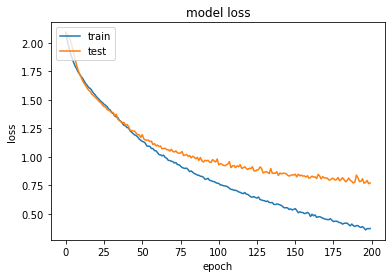

In [8]:
#dyn_noise_trim
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

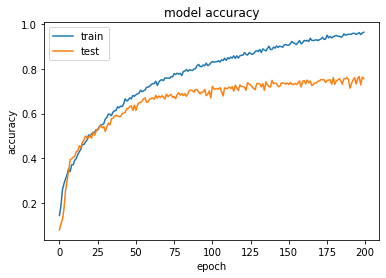

In [9]:
#dyn_noise_trim
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
predictions = model.predict_classes(x_testcnn)

In [11]:
new_Ytest = y_test.astype(int)

In [12]:
report = classification_report(new_Ytest, predictions)

In [13]:
print(report)

              precision    recall  f1-score   support

           0       0.76      0.69      0.72        55
           1       0.79      0.90      0.84       119
           2       0.85      0.68      0.75       113
           3       0.76      0.71      0.74        98
           4       0.78      0.88      0.83       119
           5       0.74      0.69      0.72       121
           6       0.59      0.59      0.59        58
           7       0.69      0.79      0.74        58

    accuracy                           0.76       741
   macro avg       0.74      0.74      0.74       741
weighted avg       0.76      0.76      0.76       741



In [14]:
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

[[ 38   7   1   1   0   2   3   3]
 [  5 107   2   2   0   2   1   0]
 [  1   7  77   2   9   8   3   6]
 [  2   7   2  70   2   7   7   1]
 [  2   2   0   0 105   3   4   3]
 [  0   0   6  14   7  84   4   6]
 [  1   6   0   3   8   4  34   2]
 [  1   0   3   0   3   3   2  46]]


In [15]:
model_name = 'Adam_Enhance_trim_only_epooch_200.h5'
#save_dir = 'Ravdess_model'
# Save model and weights
#if not os.path.isdir(save_dir):
#    os.makedirs(save_dir)
#model_path = os.path.join(save_dir, model_name)
model.save('Adam_Enhance_trim_only_epooch_200.h5')
#print('Saved trained model at %s ' % model_path)

In [16]:

loaded_model = keras.models.load_model('Adam_Enhance_trim_only_epooch_200.h5')
loaded_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 128)         768       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 128)         512       
_________________________________________________________________
activation_2 (Activation)    (None, None, 128)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)        

In [17]:
#loss, acc = loaded_model.evaluate(x_testcnn, y_test)
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

741/741 [==============================] - 0s 399us/step
Restored model, accuracy: 75.71%


In [18]:
#Test the Voice actor 23 and 24 (trim)
path2 = '/home/jovyan/at083-group21/dataset/final_test_datasaet_model1/'

lst2 = []

In [19]:
#trim
## Trim

start_time = time.time()
print("--- Start load Data. Start time: %s ---" % (start_time))
for subdir, dirs, files in os.walk(path2):

    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
            X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
            
            #####Data Augmentation
                        
            X = trim(X)
            sample_rate = np.array(sample_rate)

            
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=100).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
            file = int(file[7:8]) - 1 
            arr = mfccs, file
            lst2.append(arr)
          # If the file is not valid, skip it
        except ValueError:
            continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Start load Data. Start time: 1585285755.0022807 ---
--- Data loaded. Loading time: 13.348771810531616 seconds ---


In [20]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst2)

In [21]:
X = np.asarray(X)
y = np.asarray(y)
X.shape, y.shape

((208, 100), (208,))

In [22]:
#Do a quick test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.001, random_state=42)

In [23]:
x_traincnn2 = np.expand_dims(X_train2, axis=2)
x_testcnn2 = np.expand_dims(X_test2, axis=2)

x_traincnn2.shape, x_testcnn2.shape

((207, 100, 1), (1, 100, 1))

In [24]:
predictions2 = loaded_model.predict_classes(x_traincnn2)

In [25]:
new_Ytest2 = y_train2.astype(int)

In [26]:
report = classification_report(new_Ytest2, predictions2)

In [27]:
print(report)

              precision    recall  f1-score   support

           0       1.00      0.47      0.64        15
           1       0.65      0.94      0.77        32
           2       0.64      0.22      0.33        32
           3       0.75      0.75      0.75        32
           4       0.61      0.34      0.44        32
           5       0.50      0.84      0.63        32
           6       0.40      0.50      0.44        16
           7       0.58      0.69      0.63        16

    accuracy                           0.60       207
   macro avg       0.64      0.59      0.58       207
weighted avg       0.64      0.60      0.58       207



In [28]:
matrix2 = confusion_matrix(new_Ytest2, predictions2)
print (matrix2)

[[ 7  3  0  1  1  1  2  0]
 [ 0 30  0  1  0  0  1  0]
 [ 0  7  7  1  0  9  4  4]
 [ 0  5  0 24  0  1  1  1]
 [ 0  0  1  3 11 12  2  3]
 [ 0  0  2  2  1 27  0  0]
 [ 0  1  0  0  3  4  8  0]
 [ 0  0  1  0  2  0  2 11]]


In [29]:
#loss, acc = loaded_model.evaluate(x_testcnn, y_test)
loss2, acc2 = loaded_model.evaluate(x_traincnn2, y_train2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc2))

207/207 [==============================] - 0s 105us/step
Restored model, accuracy: 60.39%
